# Step 1: Classify A, B, C

## 0. Imports & Global Setting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets

from PIL import Image
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [2]:
SEED = 1220
BATCH_SIZE = 64
NUM_CLASSES = 3
EPOCHS = 20
IMAGE_SIZE = 224
LEARNING_RATE = 0.00095
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "../data/damage_classification"
TEST_DIR = "../data/test"
CSV_FILE = "../data/submission.csv"
FILE_EXTENSIONS = (".jpg", ".jpeg", ".png")

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
torch.cuda.empty_cache()

In [5]:
print(f"Using device: {DEVICE}")
print(f"Using GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Using Pytorch version: {torch.__version__}")
print(f"Using CUDA version: {torch.version.cuda}")
print(f"Using cuDNN version: {torch.backends.cudnn.version()}")

Using device: cuda
Using GPU: NVIDIA GeForce RTX 4070
Using Pytorch version: 2.7.0+cu128
Using CUDA version: 12.8
Using cuDNN version: 90701


## 1. Dataset / DataLoader

In [6]:
transform_train = T.Compose(
    [
        T.Resize(int(IMAGE_SIZE * 1.15)),
        T.RandomCrop(IMAGE_SIZE, padding=int(IMAGE_SIZE * 0.15)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        T.RandomRotation(15),
        T.ToTensor(),
        T.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=IMAGENET_MEAN),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [7]:
def load_dataset(data_dir, batch_size, split_ratio=0.8):
    dataset = datasets.ImageFolder(data_dir, transform=transform_train)
    train_size = int(split_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [8]:
trainloader, valloader = load_dataset(DATA_DIR, BATCH_SIZE)

## 2. Define Model

In [9]:
from torchvision.models import efficientnet_v2_s


class EfficientNetV2(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2, self).__init__()
        self.model = efficientnet_v2_s(weights="DEFAULT")
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)


model = EfficientNetV2(NUM_CLASSES).to(DEVICE)

## 3. Train & Validate

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss

        elif val_loss > self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

        else:
            self.best_score = val_loss
            self.counter = 0
            torch.save(model.state_dict(), "../output/damage_classification/models/best_model.pth")
            if self.verbose:
                print(f"✅ Model saved with loss: {val_loss:.4f}")

        return self.early_stop

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = torch.tensor(alpha, device=DEVICE) if alpha else None
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)           # prob of true class
        focal = (1-pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            focal = self.alpha[targets] * focal
        return focal.mean()

In [12]:
def train(model, trainloader, valloader, epochs):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.09)
    # criterion = FocalLoss(alpha=[1.1, 1.7, 1.0], gamma=2.0)
    # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.92, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(trainloader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()
        # scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%")
        print(f"Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")
        print("-" * 60)

        if early_stopping(val_loss, model):
            print("Early stopping")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES
    cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int32)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            for i in range(labels.size(0)):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1
                cm[label, pred] += 1

    accuracy = correct / total
    return accuracy, class_correct, class_total, cm

In [14]:
print("Training the model...")
train_losses, val_losses, train_accuracies, val_accuracies = train(model, trainloader, valloader, EPOCHS)

Training the model...


Epoch 1/20: 100%|██████████| 5/5 [00:06<00:00,  1.26s/batch]


Train Loss: 1.0614, Train Acc: 0.4424%
Validation Loss: 1.0827, Val Acc: 0.2941%
------------------------------------------------------------


Epoch 2/20: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Train Loss: 0.9915, Train Acc: 0.5093%
Validation Loss: 0.8970, Val Acc: 0.5000%
------------------------------------------------------------
Validation loss improved to 0.8970.
✅ Model saved with loss: 0.8970


Epoch 3/20: 100%|██████████| 5/5 [00:05<00:00,  1.13s/batch]


Train Loss: 0.9031, Train Acc: 0.6134%
Validation Loss: 0.8668, Val Acc: 0.5441%
------------------------------------------------------------
Validation loss improved to 0.8668.
✅ Model saved with loss: 0.8668


Epoch 4/20: 100%|██████████| 5/5 [00:05<00:00,  1.13s/batch]


Train Loss: 0.8418, Train Acc: 0.6989%
Validation Loss: 0.7668, Val Acc: 0.6471%
------------------------------------------------------------
Validation loss improved to 0.7668.
✅ Model saved with loss: 0.7668


Epoch 5/20: 100%|██████████| 5/5 [00:05<00:00,  1.14s/batch]


Train Loss: 0.7380, Train Acc: 0.7063%
Validation Loss: 0.7217, Val Acc: 0.6618%
------------------------------------------------------------
Validation loss improved to 0.7217.
✅ Model saved with loss: 0.7217


Epoch 6/20: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Train Loss: 0.6555, Train Acc: 0.7695%
Validation Loss: 0.7712, Val Acc: 0.6765%
------------------------------------------------------------


Epoch 7/20: 100%|██████████| 5/5 [00:05<00:00,  1.13s/batch]


Train Loss: 0.6078, Train Acc: 0.7881%
Validation Loss: 0.5532, Val Acc: 0.7206%
------------------------------------------------------------
Validation loss improved to 0.5532.
✅ Model saved with loss: 0.5532


Epoch 8/20: 100%|██████████| 5/5 [00:05<00:00,  1.14s/batch]


Train Loss: 0.6464, Train Acc: 0.8290%
Validation Loss: 0.6592, Val Acc: 0.6765%
------------------------------------------------------------


Epoch 9/20: 100%|██████████| 5/5 [00:05<00:00,  1.11s/batch]


Train Loss: 0.7181, Train Acc: 0.7770%
Validation Loss: 0.5680, Val Acc: 0.7353%
------------------------------------------------------------


Epoch 10/20: 100%|██████████| 5/5 [00:02<00:00,  1.75batch/s]


Train Loss: 0.6135, Train Acc: 0.8476%
Validation Loss: 0.8693, Val Acc: 0.7500%
------------------------------------------------------------


Epoch 11/20: 100%|██████████| 5/5 [00:05<00:00,  1.08s/batch]


Train Loss: 0.5739, Train Acc: 0.8401%
Validation Loss: 0.6885, Val Acc: 0.7206%
------------------------------------------------------------


Epoch 12/20: 100%|██████████| 5/5 [00:05<00:00,  1.15s/batch]


Train Loss: 0.5654, Train Acc: 0.8773%
Validation Loss: 0.7685, Val Acc: 0.7059%
------------------------------------------------------------
Early stopping triggered.
Early stopping


In [15]:
print("Evaluating the model...")
val_accuracy, val_class_correct, val_class_total, val_cm = evaluate(model, valloader)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Evaluating the model...
Validation Accuracy: 0.7206


In [16]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## 4. Evaluation & Visualization

In [17]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    fig.savefig('../output/damage_classification/images/training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

In [18]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    classes = ['A', 'B', 'C']
    num_classes = len(classes)

    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []

    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')

    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('../output/damage_classification/images/per_class_accuracy.png')
    plt.show()

    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone().float()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(
                j,
                i,
                f'{normalized_confusion_matrix[i, j]:.2f}',
                horizontalalignment="center",
                color="white" if normalized_confusion_matrix[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('../output/damage_classification/images/confusion_matrix.png')
    plt.show()

    return

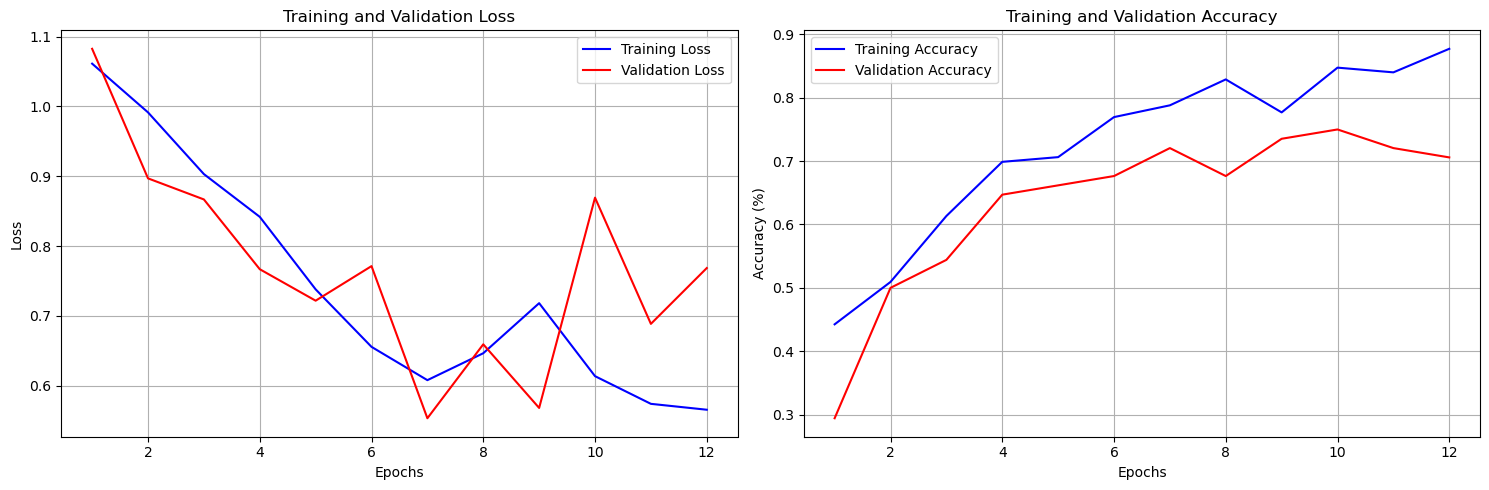

Training metrics plot saved as 'training_metrics.png'

Per-class Accuracy:
--------------------------------------------------
A: 82.35% (14/17)
B: 22.22% (4/18)
C: 93.94% (31/33)


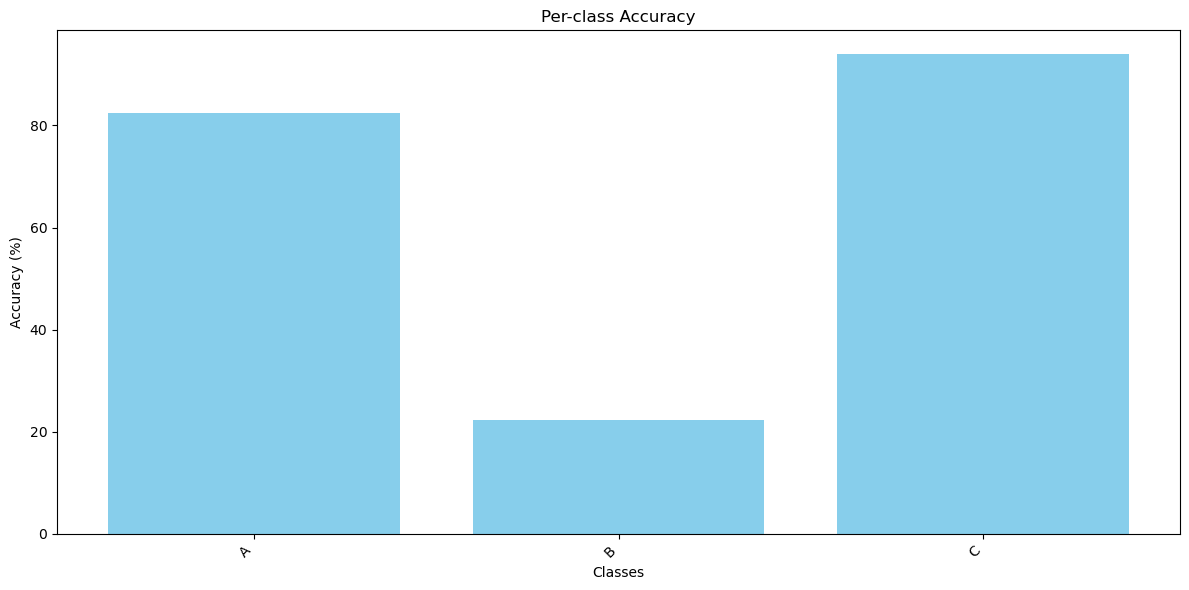

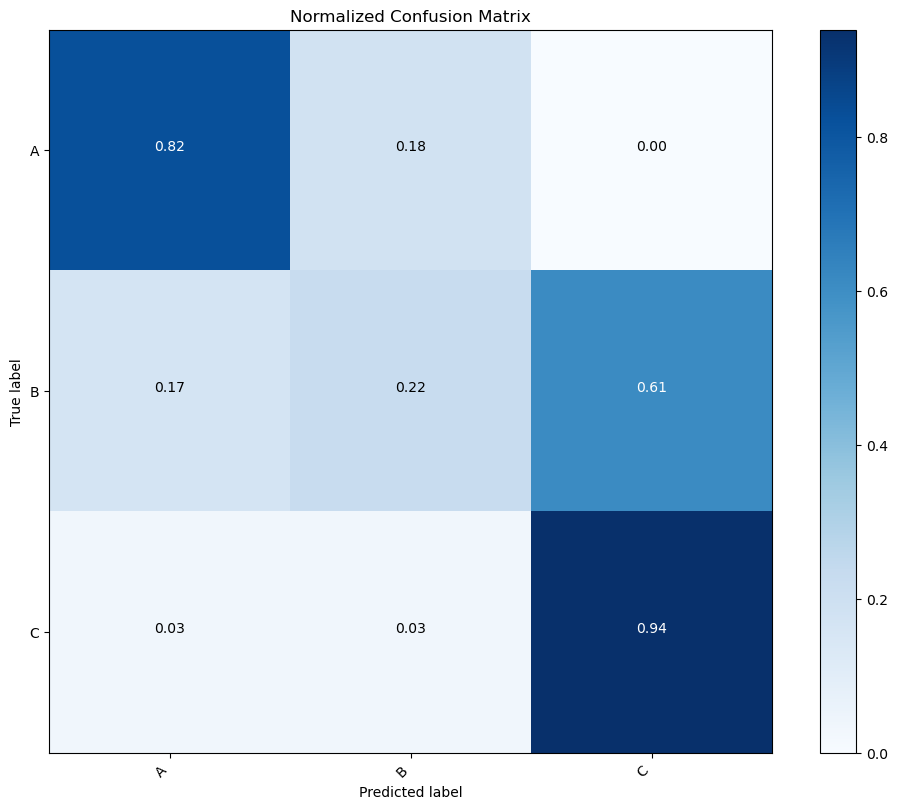

In [19]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
plot_evaluation_metrics(val_class_correct, val_class_total, val_cm)

## 5. Prediction & Submission

In [20]:
df = pd.read_csv(CSV_FILE)
print(f"Loaded CSV file with {len(df)} entries.")

classes = ['A', 'B', 'C']
columns = df.columns.tolist()
first_col = columns[0]
second_col = columns[1]
df[second_col] = df[second_col].astype('object')

model.load_state_dict(torch.load("../output/damage_classification/models/best_model.pth"))
model.to(DEVICE)
model.eval()

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing test images"):
    image_path = f"{TEST_DIR}/{int(row[first_col])}{FILE_EXTENSIONS[0]}"
    image = Image.open(image_path).convert("RGB")
    image = transform_train(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        df.at[idx, second_col] = classes[predicted.item()]

df.to_csv("../output/damage_classification/submission.csv", index=False)
print("Submission file saved as 'submission.csv'")

Loaded CSV file with 55 entries.


Processing test images: 100%|██████████| 55/55 [00:01<00:00, 27.84it/s]

Submission file saved as 'submission.csv'
